<a href="https://colab.research.google.com/github/nathanzilgo/Audio-Processing/blob/main/music_generation_LSTM%20documented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Este notebook tem como objetivo treinar uma rede neural LSTM para geração de músicas curtas, baseadas em base de dados de compositores no formato MIDI
Este artigo da documentação oficial do tensorflow foi utilizado como referência:
https://www.tensorflow.org/tutorials/audio/music_generation

In [40]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


Para poder sintetizar MIDI para WAV e testar os outputs:

In [41]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Para trabalhar com MIDI:

In [42]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Libs:

In [43]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [44]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Dataset de treinamento:
Utilizando composições em MIDI do Chopin

investigar e testar esse aqui tb:
http://www.piano-midi.de/

In [45]:
chopin_dir = pathlib.Path('data/chopinMidi')
chopin_origin = 'http://www.piano-midi.de/zip/chopin.zip'
chopin_fname = 'chopin.zip'
# maestro_origin = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'
# maestro_dir = pathlib.Path('data/maestro-v2.0.0')

In [46]:

if not chopin_dir.exists():
  tf.keras.utils.get_file(
      chopin_fname,
      origin= chopin_origin,
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [47]:
filenames = glob.glob(str('data/*.mid*'))
print('Number of files:', len(filenames))


Number of files: 48


Seleciona um arquivo arbitrário do dataset para visualização

In [48]:
import random
random_index = random.randint(0, len(filenames)-1)

sample_file = filenames[random_index]
print(sample_file)

data/chpn_op25_e2.mid


In [49]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [50]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

Testa o arquivo selecionado em MIDI





In [51]:
display_audio(pm)

Identificação de instrumentos:

In [52]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for x in pm.instruments:
  print(pretty_midi.program_to_instrument_name(x.program))

Number of instruments: 2
Instrument name: Acoustic Grand Piano
Acoustic Grand Piano
Acoustic Grand Piano


Identificação das notas e duração:

In [53]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=72, note_name=C5, duration=0.3257
1: pitch=72, note_name=C5, duration=0.1115
2: pitch=73, note_name=C#5, duration=0.1112
3: pitch=71, note_name=B4, duration=0.1109
4: pitch=72, note_name=C5, duration=0.1100
5: pitch=75, note_name=D#5, duration=0.1064
6: pitch=73, note_name=C#5, duration=0.0953
7: pitch=72, note_name=C5, duration=0.1110
8: pitch=73, note_name=C#5, duration=0.1112
9: pitch=71, note_name=B4, duration=0.1107


In [54]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

Notas do arquivo de teste mais detalhadas, com afinação (pitch), inicio, fim, tempo (step) e duração:

In [55]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,72,0.858533,1.184239,0.000000,0.325706
1,72,1.184239,1.295702,0.325706,0.111463
2,73,1.283317,1.394499,0.099079,0.111182
3,71,1.382171,1.493069,0.098854,0.110898
4,72,1.480800,1.590779,0.098629,0.109979


Nome das notas presentes no sample de teste:

In [56]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C5', 'C5', 'C#5', 'B4', 'C5', 'D#5', 'C#5', 'C5', 'C#5', 'B4'],
      dtype='<U3')

Plota um gráfico das notas, duração e step em uma linha temporal de piano:

In [57]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

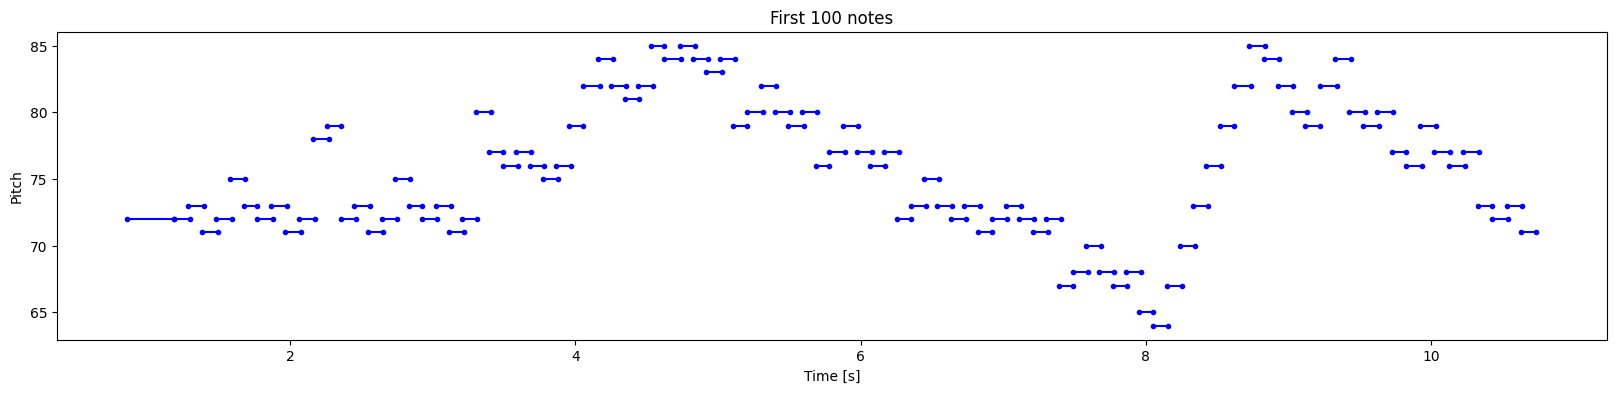

In [58]:
plot_piano_roll(raw_notes, count=100)

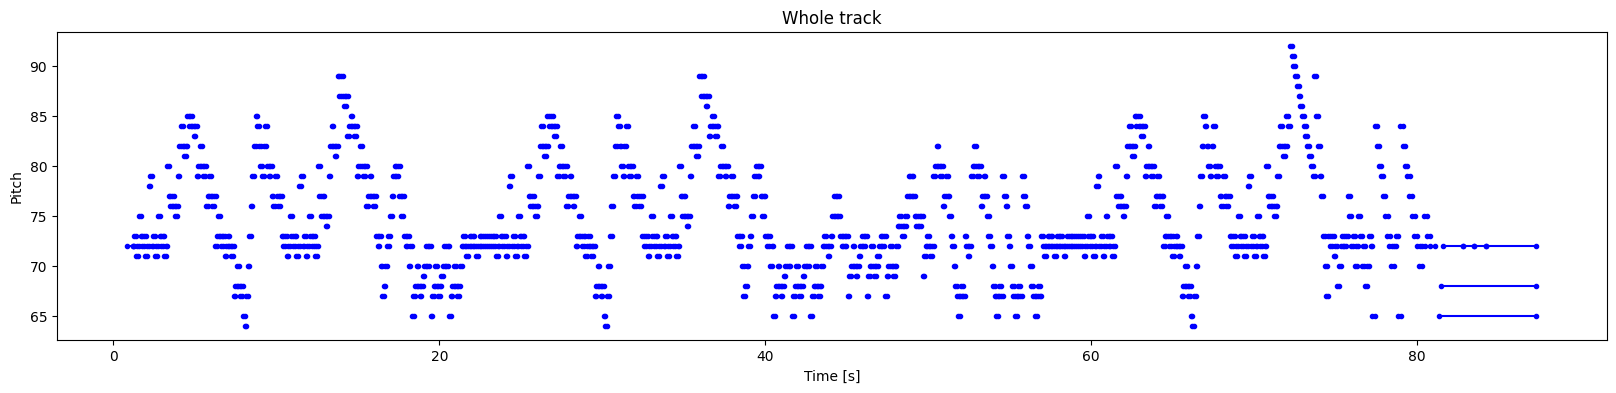

In [59]:
plot_piano_roll(raw_notes)

Plota a distribuição de frequencia das notas:

In [60]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

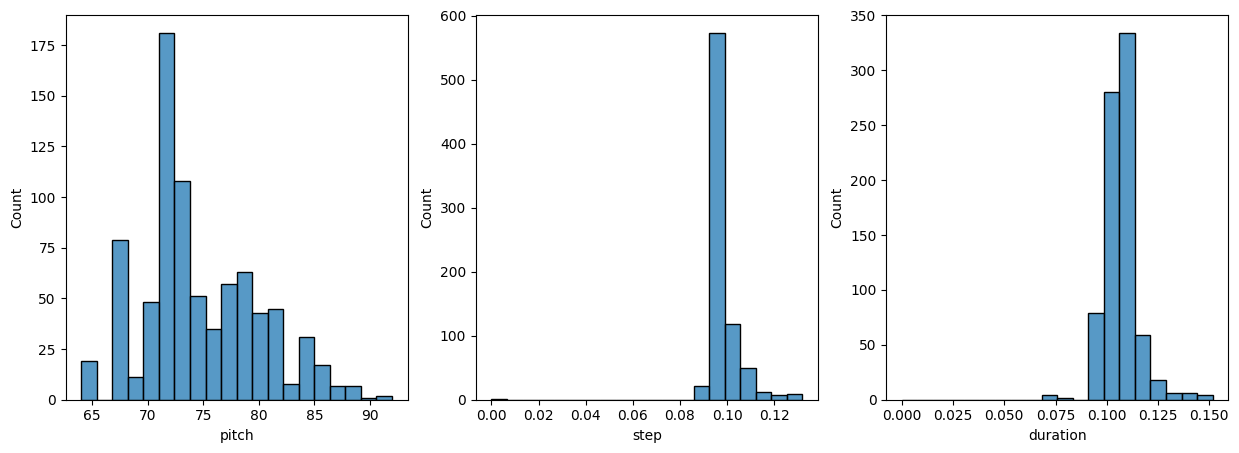

In [61]:
plot_distributions(raw_notes)

## Cria um MIDI com notas fornecidas

In [62]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [63]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [64]:
display_audio(example_pm)

Definição do número de notas que serão utilizadas no treino com o dataset:

In [65]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [66]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 5364


## Criação de DataSet das notas processadas:

In [67]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [68]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Fine tuning com keras tuner:

In [69]:
!pip install keras_tuner
from keras_tuner import HyperParameters

hp = HyperParameters()
seq_length = hp.Int('seq_length', min_value=20, max_value=100, step=5)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Treinaremos o modelo em batches de sequencias de notas, em que o tamanho das sequencias é um dos parametros a serem tunados ✌

In [70]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length + 1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use hyperparameter tuning. The size of the vocabulary (vocab_size) is set to 128 representing all the pitches supported by pretty_midi.



In [105]:
hp = HyperParameters()
vocab_size = 128
seq_length = 100

seq_ds = create_sequences(notes_ds, seq_length) # call this function after the model being trained
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [106]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.71875    0.         0.06134967]
 [0.7265625  0.06134967 0.06134967]
 [0.71875    0.06134967 0.06134967]
 [0.7265625  0.06134967 0.06134967]
 [0.71875    0.06134967 0.06134967]
 [0.7109375  0.06134967 0.06134967]
 [0.7578125  0.06134967 0.06134967]
 [0.71875    0.         0.06134967]
 [0.7265625  0.06134967 0.06134967]
 [0.71875    0.06134967 0.06134967]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=78.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.06006>}


In [107]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [108]:
train_ds.element_spec

(TensorSpec(shape=(64, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Treino do modelo:
O modelo terá 3 saídas para cada variável de nota
Para step e duration, utilizamos uma função de perda baseada no erro quadrático médio, influenciando o modelo a produzir valores não negativos

In [109]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [110]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

# Get the list of trainable variables in your model
trainable_vars = model.trainable_variables
# Build the optimizer with the trainable variables
optimizer.build(trainable_vars)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [111]:
# def build_model(hp, seq_length=20):
#   input_shape = (seq_length, 3)
#   learning_rate = 0.005

#   inputs = tf.keras.Input(input_shape)
#   x = tf.keras.layers.LSTM(128)(inputs)

#   outputs = {
#     'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
#     'step': tf.keras.layers.Dense(1, name='step')(x),
#     'duration': tf.keras.layers.Dense(1, name='duration')(x),
#   }

#   model = tf.keras.Model(inputs, outputs)

#   loss = {
#       'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
#           from_logits=True),
#       'step': mse_with_positive_pressure,
#       'duration': mse_with_positive_pressure,
#   }

#   optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# # Get the list of trainable variables in your model
#   trainable_vars = model.trainable_variables
# # Build the optimizer with the trainable variables
#   optimizer.build(trainable_vars)

#   model.compile(loss=loss, optimizer=optimizer)

#   return model

# #model = build_model(hp)
# #model.summary()

In [112]:
from keras_tuner import BayesianOptimization

tuner = BayesianOptimization(
    model,
    objective='val_loss',
    max_trials=5,
    directory='myDir'
)

tuner.search_space_summary()

Search space summary
Default search space size: 0


In [113]:
tuner.search(notes_ds, epochs=20)

In [114]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
# best_seq_length = best_hyperparameters.get('length')

In [115]:
# best_seq_length

In [116]:
seq_ds = create_sequences(notes_ds, seq_length) # call this function after the model being trained
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [117]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset (change this to get the best hp)
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [118]:
# model = build_model(hp, best_seq_length)
model.build(hp)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

Calcula a função de perda, nota-se que o pitch loss é significantemente maior do que step e duration.
Loss é a perda total computada somando todas as outras perdas.

In [119]:
losses = model.evaluate(train_ds, return_dict=True)
losses

82/82 [==============================] - 7s 58ms/step - loss: 5.9504 - duration_loss: 0.0721 - pitch_loss: 4.8556 - step_loss: 1.0227


{'loss': 5.950430393218994,
 'duration_loss': 0.07211140543222427,
 'pitch_loss': 4.855644226074219,
 'step_loss': 1.022676944732666}

In [120]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [121]:
model.evaluate(train_ds, return_dict=True)

82/82 [==============================] - 5s 49ms/step - loss: 1.3376 - duration_loss: 0.0721 - pitch_loss: 4.8556 - step_loss: 1.0227


{'loss': 1.3375707864761353,
 'duration_loss': 0.07211140543222427,
 'pitch_loss': 4.855644226074219,
 'step_loss': 1.022676944732666}

In [122]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [123]:
%%time
epochs = 60

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/60
82/82 [==============================] - 10s 113ms/step - loss: 0.2933 - duration_loss: 0.0340 - pitch_loss: 4.0799 - step_loss: 0.0554
Epoch 2/60
82/82 [==============================] - 9s 112ms/step - loss: 0.2410 - duration_loss: 0.0282 - pitch_loss: 3.5266 - step_loss: 0.0365
Epoch 3/60
82/82 [==============================] - 9s 116ms/step - loss: 0.2335 - duration_loss: 0.0271 - pitch_loss: 3.4713 - step_loss: 0.0328
Epoch 4/60
82/82 [==============================] - 10s 118ms/step - loss: 0.2308 - duration_loss: 0.0261 - pitch_loss: 3.4406 - step_loss: 0.0326
Epoch 5/60
82/82 [==============================] - 10s 118ms/step - loss: 0.2295 - duration_loss: 0.0269 - pitch_loss: 3.4129 - step_loss: 0.0319
Epoch 6/60
82/82 [==============================] - 9s 106ms/step - loss: 0.2249 - duration_loss: 0.0256 - pitch_loss: 3.3671 - step_loss: 0.0309
Epoch 7/60
82/82 [==============================] - 10s 118ms/step - loss: 0.2253 - duration_loss: 0.0253 - pitch_loss: 3

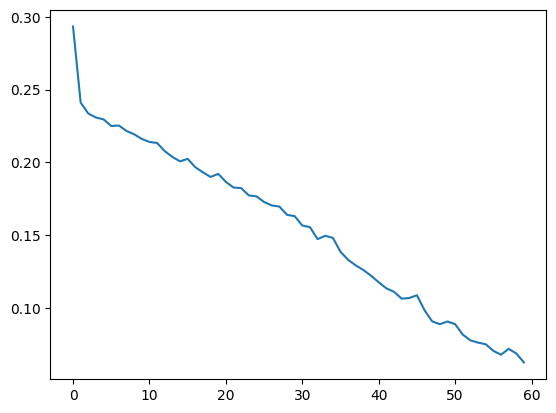

In [124]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Predição de notas seguintes
A função abaixo gera uma nota baseada numa sequencia prévia de notas.

In [125]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [126]:
temperature = 5.0
num_predictions = 200

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 24ms/step


In [127]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,82,0.109143,0.099643,0.109143,0.208786
1,77,0.090267,0.000000,0.199410,0.199410
2,80,0.083674,0.000000,0.283084,0.283084
3,75,0.084209,0.000000,0.367293,0.367293
4,79,0.084054,0.000000,0.451347,0.451347
5,70,0.083913,0.000000,0.535259,0.535259
6,43,0.084002,0.000000,0.619261,0.619261
7,92,0.081686,0.000000,0.700948,0.700948
8,75,0.085460,0.000000,0.786408,0.786408
9,88,0.083973,0.000000,0.870381,0.870381


In [128]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

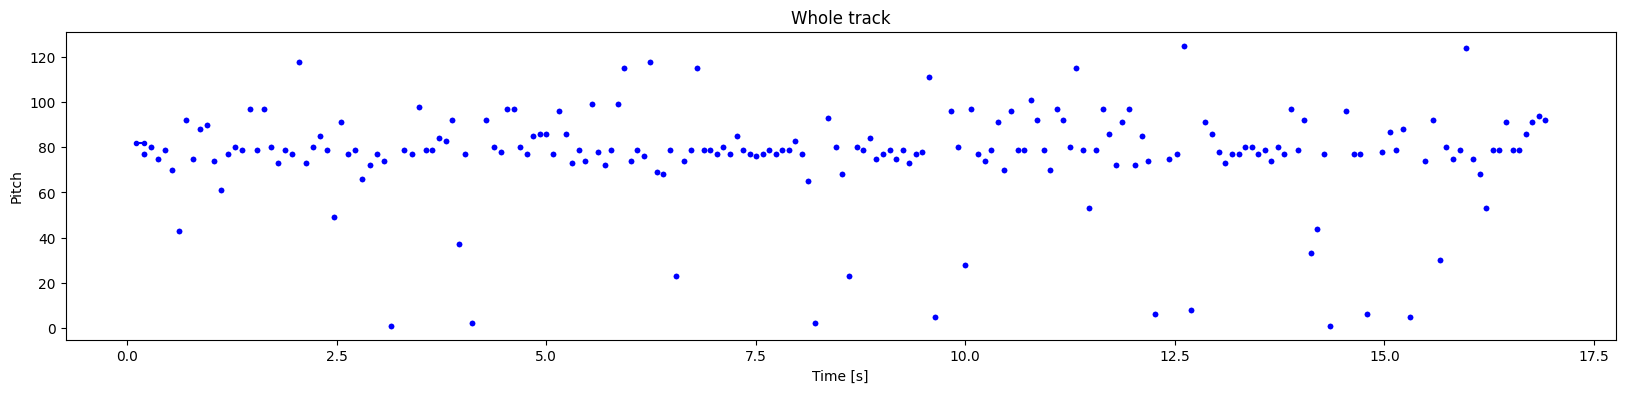

In [129]:
plot_piano_roll(generated_notes)

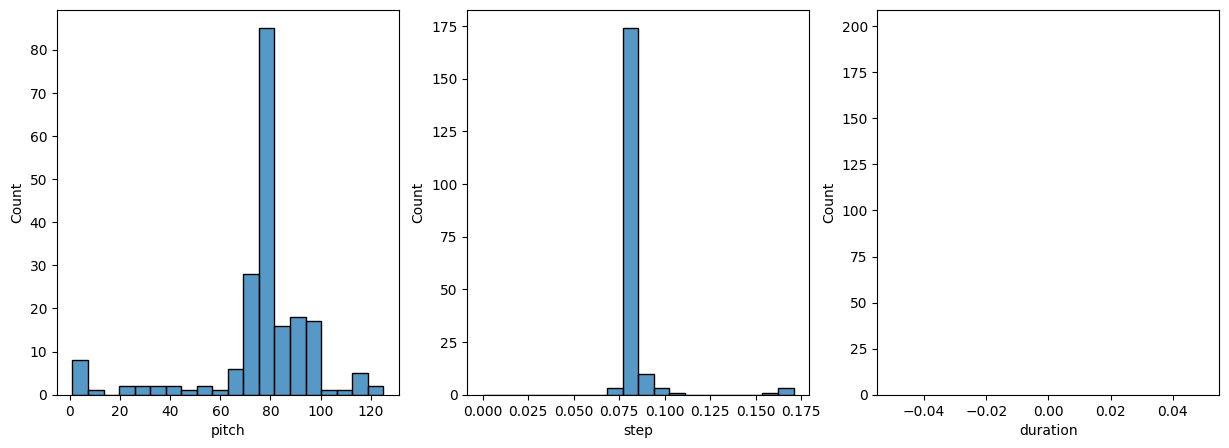

In [130]:
plot_distributions(generated_notes)